In [1]:
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import os
import wandb

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pretrained CelebA DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")

# Access the UNet model from the pipeline
model = pipeline.unet
model = model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


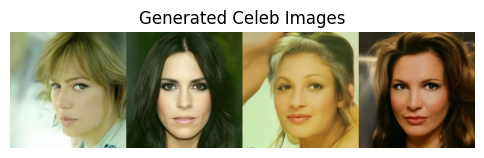

In [3]:
@torch.no_grad()
def sample(model, scheduler, num_images=4):
    model.eval()
    images = torch.randn((num_images, 3, 256, 256)).to(device)
    scheduler.set_timesteps(50)

    for t in scheduler.timesteps:
        noise_pred = model(images, t).sample
        images = scheduler.step(noise_pred, t, images).prev_sample
        
    return images

samples = sample(model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # from [-1, 1] to [0, 1]

grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated Celeb Images") ##
plt.show()

### The Anime Dataset ###

In [3]:
import random
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define dataset class for loading images
class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None, limit=1000):
        self.root_dir = root_dir
        # Get all image files and shuffle them randomly
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(self.image_files)  # Shuffle the image list
        self.image_files = self.image_files[:limit]  # Limit to the first 'limit' images
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image

### a. Improved DataLoading ###

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),          
    transforms.Normalize((0.5,), (0.5,))  
])

# Load the dataset with a limit of 1000 random images
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=1000)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
import time
import torch
import psutil

batch_times = []
cpu_usages = []
process = psutil.Process()  # To measure CPU usage of this process
start_epoch = time.time()

for i, batch in enumerate(dataloader):
    batch_start = time.time()
    batch = batch.to(device)
    torch.cuda.synchronize()  # If you want to be strict on GPU timing
    batch_end = time.time()
    batch_times.append(batch_end - batch_start)
    cpu_usages.append(process.cpu_percent(interval=0.01)) # Record CPU Usage

end_epoch = time.time()

print(f"Epoch time: {end_epoch - start_epoch:.3f} seconds")
print(f"Average batch time: {sum(batch_times)/len(batch_times):.4f} seconds")
print(f"Max batch time: {max(batch_times):.4f} seconds")
print(f"Min batch time: {min(batch_times):.4f} seconds")
print(f"Average CPU usage: {sum(cpu_usages)/len(cpu_usages):.2f}%")
print(f"Peak CPU usage: {max(cpu_usages):.2f}%")

Epoch time: 2.675 seconds
Average batch time: 0.0029 seconds
Max batch time: 0.0034 seconds
Min batch time: 0.0016 seconds
Average CPU usage: 296.08%
Peak CPU usage: 393.60%


In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),         
    transforms.Normalize((0.5,), (0.5,)) 
])

# Load dataset
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=1000)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,           # Adjust based on your CPU cores
    pin_memory=True,         # Speeds up transfer to GPU
    prefetch_factor=2,       # Number of batches per worker to prefetch
    persistent_workers=True  # Keeps workers alive between epochs
)

In [7]:
import time
import torch
import psutil

batch_times = []
cpu_usages = []
process = psutil.Process()  # To measure CPU usage of this process
start_epoch = time.time()

for i, batch in enumerate(dataloader):
    batch_start = time.time()
    batch = batch.to(device, non_blocking=True)
    torch.cuda.synchronize()  # If you want to be strict on GPU timing
    batch_end = time.time()
    batch_times.append(batch_end - batch_start)
    cpu_usages.append(process.cpu_percent(interval=0.01)) # Record CPU Usage

end_epoch = time.time()

print(f"Epoch time: {end_epoch - start_epoch:.3f} seconds")
print(f"Average batch time: {sum(batch_times)/len(batch_times):.4f} seconds")
print(f"Max batch time: {max(batch_times):.4f} seconds")
print(f"Min batch time: {min(batch_times):.4f} seconds")
print(f"Average CPU usage: {sum(cpu_usages)/len(cpu_usages):.2f}%")
print(f"Peak CPU usage: {max(cpu_usages):.2f}%")

Epoch time: 1.011 seconds
Average batch time: 0.0014 seconds
Max batch time: 0.0017 seconds
Min batch time: 0.0008 seconds
Average CPU usage: 55.90%
Peak CPU usage: 196.90%


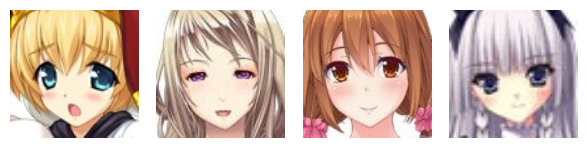

In [8]:
def unnormalize(img):
    img = img / 2 + 0.5  
    return img

# Visualize a batch of images
def visualize_batch(dataloader):
    images = next(iter(dataloader))
    images = unnormalize(images).permute(0, 2, 3, 1).numpy()  

    # Create a grid to display the images
    plt.figure(figsize=(6, 3))  
    for i in range(4):  
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i], interpolation='nearest') 
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_batch(dataloader)

### Finetuning Model on the Anime Dataset (Resolution: 256x256) ###

In [15]:
def log_epoch_stats(epoch, avg_loss, avg_step_time, total_epoch_time, avg_cuda_alloc, avg_cuda_reserved, avg_cpu_mem):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Avg Loss:           {avg_loss:.6f}")
    print(f"  Avg Step Time:      {avg_step_time:.4f} sec")
    print(f"  Total Epoch Time:   {total_epoch_time:.2f} sec")
    print(f"  Avg CUDA Alloc:     {avg_cuda_alloc:.2f} MB")
    print(f"  Avg CUDA Reserved:  {avg_cuda_reserved:.2f} MB")
    print(f"  Avg CPU Mem:        {avg_cpu_mem:.2f} MB\n")

    wandb.log({
        "epoch": epoch + 1,
        "epoch_avg_loss": avg_loss,
        "epoch_avg_step_time_sec": avg_step_time,
        "epoch_total_time_sec": total_epoch_time,
        "epoch_avg_cuda_alloc_MB": avg_cuda_alloc,
        "epoch_avg_cuda_reserved_MB": avg_cuda_reserved,
        "epoch_avg_cpu_mem_MB": avg_cpu_mem,
    })

In [10]:
import gc
import torch

def clean_basic():
    """
    Delete common variables and free unused GPU/CPU memory.
    """
    for name in [
        'pipeline',
        'model',
        'optimizer',
        'dataloader'
        'images', 'timesteps', 'noise', 'noisy_images', 'noise_pred', 'loss'
    ]:
        try:
            del globals()[name]
        except:
            pass

    gc.collect()
    torch.cuda.empty_cache()

# Usage:
clean_basic()

In [11]:
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=100)
dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,           #
    pin_memory=True,         # Speeds up transfer to GPU
    prefetch_factor=2,       # Number of batches per worker to prefetch
    persistent_workers=True  # Keeps workers alive between epochs
)
accumulation_steps = 4  # Gradient accumulation

In [12]:
# Load the pretrained CelebA DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
model = pipeline.unet
model = model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [13]:
wandb.init(
    project="DDPM_Project",          
    name="exp_baseline_256",             
    config={
        "epochs": 5,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": scheduler.config,
        "model": str(model.__class__.__name__),
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yc4528 (yc4528-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
from torch.optim import Adam
import psutil

optimizer = Adam(model.parameters(), lr=1e-5)
model.train()
num_epochs = 5

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []
    optimizer.zero_grad()

    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cuda")  # fp32

        batch_size = images.size(0)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cuda").long()
        noise = torch.randn_like(images)
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Forward pass
        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record stats
        epoch_loss += loss.item()
        epoch_steps += 1
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))

    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

wandb.finish()

Epoch 1/5:   0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/5: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]



Epoch 1 Summary:
  Avg Loss:           0.010380
  Avg Step Time:      0.7126 sec
  Total Epoch Time:   35.83 sec
  Avg CUDA Alloc:     1796.51 MB
  Avg CUDA Reserved:  7173.92 MB
  Avg CPU Mem:        1634.75 MB



Epoch 2/5: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch 2 Summary:
  Avg Loss:           0.010020
  Avg Step Time:      0.7050 sec
  Total Epoch Time:   35.41 sec
  Avg CUDA Alloc:     1796.55 MB
  Avg CUDA Reserved:  7200.00 MB
  Avg CPU Mem:        1634.88 MB



Epoch 3/5: 100%|██████████| 50/50 [00:34<00:00,  1.43it/s]



Epoch 3 Summary:
  Avg Loss:           0.012232
  Avg Step Time:      0.6970 sec
  Total Epoch Time:   35.00 sec
  Avg CUDA Alloc:     1797.10 MB
  Avg CUDA Reserved:  7200.00 MB
  Avg CPU Mem:        1634.94 MB



Epoch 4/5: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch 4 Summary:
  Avg Loss:           0.005794
  Avg Step Time:      0.7052 sec
  Total Epoch Time:   35.41 sec
  Avg CUDA Alloc:     1798.04 MB
  Avg CUDA Reserved:  7200.00 MB
  Avg CPU Mem:        1634.99 MB



Epoch 5/5: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Epoch 5 Summary:
  Avg Loss:           0.006495
  Avg Step Time:      0.7008 sec
  Total Epoch Time:   35.19 sec
  Avg CUDA Alloc:     1796.40 MB
  Avg CUDA Reserved:  7200.00 MB
  Avg CPU Mem:        1635.02 MB



epoch,▁▃▅▆█
epoch_avg_cpu_mem_MB,▁▄▆▇█
epoch_avg_cuda_alloc_MB,▁▂▄█▁
epoch_avg_cuda_reserved_MB,▁████
epoch_avg_loss,▆▆█▁▂
epoch_avg_step_time_sec,█▅▁▅▃
epoch_total_time_sec,█▄▁▄▃
epoch,5
epoch_avg_cpu_mem_MB,1635.02109
epoch_avg_cuda_alloc_MB,1796.39939
epoch_avg_cuda_reserved_MB,7200


In [10]:
clean_basic()

NameError: name 'clean_basic' is not defined

### Improved Training with Gradient Checkpointing ###

In [18]:
# Load the pretrained CelebA DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
model = pipeline.unet
model = model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [27]:
wandb.init(
    project="DDPM_Project",          
    name="exp_optimised_256",             
    config={
        "epochs": 5,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": scheduler.config,
        "model": str(model.__class__.__name__),
    }
)

In [20]:
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=100)
dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,           #
    pin_memory=True,         # Speeds up transfer to GPU
    prefetch_factor=2,       # Number of batches per worker to prefetch
    persistent_workers=True  # Keeps workers alive between epochs
)
accumulation_steps = 4  # Gradient accumulation

In [7]:
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

# Enable gradient checkpointing for memory savings
model.enable_gradient_checkpointing()

# Optimizer and scaler for mixed precision
optimizer = Adam(model.parameters(), lr=1e-5)
scaler = GradScaler()

model.train()
num_epochs = 5

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []

    optimizer.zero_grad()
    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cuda").half()  # Ensure input matches FP16
        
        # Sample random timesteps
        batch_size = images.size(0)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cuda").long()

        # Generate random noise
        noise = torch.randn_like(images)

        # Add noise to images
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Forward pass with mixed precision
        with autocast():
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        # Normalize loss for gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        # Update weights every `accumulation_steps`
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()


        epoch_loss += loss.item()
        epoch_steps += 1
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))


    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

# --- FINISH WANDB RUN ---
wandb.finish()

/var/tmp/ipykernel_3133508/1620096436.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|          | 0/63 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/var/tmp/ipykernel_3133508/1620096436.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5:   0%|          | 0/63 [00:01<?, ?it/s]


NameError: name 'accumulation_steps' is not defined

In [28]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import psutil
from tqdm import tqdm
import time

# Function to extract patches from images
def extract_patches(images, patch_size, stride):
    """
    Extracts patches from a batch of images.

    Args:
        images (torch.Tensor): Tensor of shape (B, C, H, W).
        patch_size (int): Size of each square patch.
        stride (int): Stride between patches.

    Returns:
        patches (torch.Tensor): Tensor of patches with shape (B * num_patches, C, patch_size, patch_size).
        num_patches_per_image (int): Number of patches per image.
    """
    # Unfold the height and width dimensions to create patches
    patches = images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # Reshape to (B * num_patches, C, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    num_patches_per_image = patches.size(1) * patches.size(2)  # Number of patches per image
    patches = patches.view(-1, images.size(1), patch_size, patch_size)
    return patches, num_patches_per_image

# Training setup
optimizer = Adam(model.parameters(), lr=1e-5)
model.train()
num_epochs = 3

# Patch parameters
patch_size = 256  # Size of the patches
stride = 256     # Stride between patches (for non-overlapping patches, set stride = patch_size)
mini_batch_size = 16  # Number of patches to process at once

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []
    optimizer.zero_grad()

    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cpu")  # Keep images on CPU initially to save GPU memory

        # Extract patches from images (on CPU)
        patches, num_patches_per_image = extract_patches(images, patch_size, stride)

        # Process patches in mini-batches
        for patch_start in range(0, patches.size(0), mini_batch_size):
            # Create a mini-batch of patches
            patch_batch = patches[patch_start:patch_start + mini_batch_size].to("cuda")

            # Sample random timesteps for diffusion
            batch_size = patch_batch.size(0)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cuda").long()
            noise = torch.randn_like(patch_batch)

            # Add noise to patches
            noisy_patches = scheduler.add_noise(patch_batch, noise, timesteps)

            # Forward pass
            noise_pred = model(noisy_patches, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record stats
            epoch_loss += loss.item()
            epoch_steps += 1

        # Record memory usage stats after processing all patches for this batch
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))

    # Calculate and log epoch statistics
    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

# Finish training
wandb.finish()

Epoch 1/3:   0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/3: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s]



Epoch 1 Summary:
  Avg Loss:           0.005349
  Avg Step Time:      0.7186 sec
  Total Epoch Time:   36.07 sec
  Avg CUDA Alloc:     1793.43 MB
  Avg CUDA Reserved:  7152.00 MB
  Avg CPU Mem:        1688.49 MB



Epoch 2/3: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]



Epoch 2 Summary:
  Avg Loss:           0.008644
  Avg Step Time:      0.6992 sec
  Total Epoch Time:   35.10 sec
  Avg CUDA Alloc:     1792.29 MB
  Avg CUDA Reserved:  7152.00 MB
  Avg CPU Mem:        1690.46 MB



Epoch 3/3: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Epoch 3 Summary:
  Avg Loss:           0.008890
  Avg Step Time:      0.7002 sec
  Total Epoch Time:   35.15 sec
  Avg CUDA Alloc:     1792.19 MB
  Avg CUDA Reserved:  7152.00 MB
  Avg CPU Mem:        1690.56 MB



epoch,▁▅█
epoch_avg_cpu_mem_MB,▁██
epoch_avg_cuda_alloc_MB,█▂▁
epoch_avg_cuda_reserved_MB,▁▁▁
epoch_avg_loss,▁██
epoch_avg_step_time_sec,█▁▁
epoch_total_time_sec,█▁▁
epoch,3
epoch_avg_cpu_mem_MB,1690.56
epoch_avg_cuda_alloc_MB,1792.19105
epoch_avg_cuda_reserved_MB,7152


In [20]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import psutil
from tqdm import tqdm
import time

# Function to extract patches from images
def extract_patches(images, patch_size, stride):
    """
    Extracts patches from a batch of images.

    Args:
        images (torch.Tensor): Tensor of shape (B, C, H, W).
        patch_size (int): Size of each square patch.
        stride (int): Stride between patches.

    Returns:
        patches (torch.Tensor): Tensor of patches with shape (B * num_patches, C, patch_size, patch_size).
        num_patches_per_image (int): Number of patches per image.
    """
    # Unfold the height and width dimensions to create patches
    patches = images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # Reshape to (B * num_patches, C, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    num_patches_per_image = patches.size(1) * patches.size(2)  # Number of patches per image
    patches = patches.view(-1, images.size(1), patch_size, patch_size)
    return patches, num_patches_per_image

# Training setup
optimizer = Adam(model.parameters(), lr=1e-5)
model.train()
num_epochs = 5

# Patch parameters
patch_size = 32  # Size of the patches
stride = 32      # Stride between patches (for non-overlapping patches, set stride = patch_size)
mini_batch_size = 16  # Number of patches to process at once

# Create a CUDA stream for asynchronous data transfer
transfer_stream = torch.cuda.Stream()

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []
    optimizer.zero_grad()

    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cpu")  # Keep images on CPU initially to save GPU memory

        # Extract patches from images (on CPU)
        patches, num_patches_per_image = extract_patches(images, patch_size, stride)

        # Initialize placeholders for the next mini-batch
        next_patch_batch = None

        # Process patches in mini-batches
        for patch_start in range(0, patches.size(0), mini_batch_size):
            # Transfer the next mini-batch of patches to GPU asynchronously
            if next_patch_batch is None:
                # For the first iteration, load the current mini-batch directly
                patch_batch = patches[patch_start:patch_start + mini_batch_size].to("cuda", non_blocking=True)
            else:
                # Use the preloaded batch from the previous iteration
                patch_batch = next_patch_batch

            # Preload the next mini-batch while the current one is being processed
            next_patch_start = patch_start + mini_batch_size
            if next_patch_start < patches.size(0):
                with torch.cuda.stream(transfer_stream):
                    next_patch_batch = patches[next_patch_start:next_patch_start + mini_batch_size].to(
                        "cuda", non_blocking=True
                    )

            # Sample random timesteps for diffusion
            batch_size = patch_batch.size(0)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cuda").long()
            noise = torch.randn_like(patch_batch)

            # Add noise to patches
            noisy_patches = scheduler.add_noise(patch_batch, noise, timesteps)

            # Forward pass
            noise_pred = model(noisy_patches, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Synchronize the transfer stream with the default stream
            torch.cuda.synchronize()

            # Record stats
            epoch_loss += loss.item()
            epoch_steps += 1

        # Record memory usage stats after processing all patches for this batch
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))

    # Calculate and log epoch statistics
    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

# Finish training
wandb.finish()

Epoch 1/5:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Epoch 1 Summary:
  Avg Loss:           0.009404
  Avg Step Time:      0.1640 sec
  Total Epoch Time:   65.72 sec
  Avg CUDA Alloc:     221.42 MB
  Avg CUDA Reserved:  894.00 MB
  Avg CPU Mem:        186.35 MB



Error: You must call wandb.init() before wandb.log()

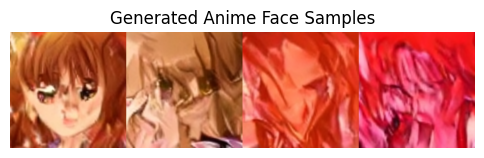

In [29]:
@torch.no_grad()
def sample(model, scheduler, num_images=4):
    model.eval()
    images = torch.randn((num_images, 3, 256, 256)).to('cuda')
    scheduler.set_timesteps(100)

    for t in scheduler.timesteps:
        noise_pred = model(images, t).sample
        images = scheduler.step(noise_pred, t, images).prev_sample
        
    return images

samples = sample(model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # from [-1, 1] to [0, 1]

grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated Anime Face Samples")
plt.show()

In [10]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import psutil
from tqdm import tqdm
import time

scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")

def extract_patches(images, patch_size):
    """
    images: (B, C, H, W)
    Returns: (num_patches_total, C, patch_size, patch_size)
    """
    B, C, H, W = images.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image must be divisible by patch size"
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B, C, nH, nW, pH, pW)
    patches = patches.permute(0, 2, 3, 1, 4, 5)  # (B, nH, nW, C, pH, pW)
    patches = patches.contiguous().reshape(-1, C, patch_size, patch_size)  # (B * nH * nW, C, pH, pW)
    return patches

patch_size = 64  # Or any size dividing your image

optimizer = Adam(model.parameters(), lr=1e-5)
model.to('cuda')
model.train()
num_epochs = 5

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []
    optimizer.zero_grad()

    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cuda")  # fp32

        # --- PATCHIFY BATCH ---
        patches = extract_patches(images, patch_size)  # (N_patches, C, patch_size, patch_size)
        batch_patches = patches.size(0)

        # Sample random timesteps for each patch
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_patches,), device="cuda").long()
        noise = torch.randn_like(patches)
        noisy_patches = scheduler.add_noise(patches, noise, timesteps)

        # Forward pass
        noise_pred = model(noisy_patches.to('cuda'), timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record stats
        epoch_loss += loss.item()
        epoch_steps += 1
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))

    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

print("Training finished.")

Epoch 1/5:   0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/5: 100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


Epoch 1 Summary:
  Avg Loss:           0.009209
  Avg Step Time:      0.5970 sec
  Total Epoch Time:   29.98 sec
  Avg CUDA Alloc:     1787.56 MB
  Avg CUDA Reserved:  6800.76 MB
  Avg CPU Mem:        1456.78 MB



Error: You must call wandb.init() before wandb.log()

### Working in the Latent Space ###

### Post-Training Quantization ###

In [11]:
import torch
from torch.quantization import QuantStub, DeQuantStub

model = pipeline.unet
unet_model = model.to('cpu')  # Move the model to GPU if available
#noise_pred = model(noisy_images, timesteps).sample
scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")

class QuantizedUNet(torch.nn.Module):
    def __init__(self, unet_model):
        super(QuantizedUNet, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.unet = unet_model
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x, timesteps):
        # Quantize the input
        x = self.quant(x)

        # Call the original U-Net forward method
        output = self.unet(x, timesteps)


        # Dequantize the output
        #x = self.dequant(x)
        return x

# Wrap your U-Net model
quantized_model = QuantizedUNet(model).to('cpu')
quantized_model.qconfig = torch.quantization.get_default_qconfig("qnnpack")
torch.quantization.prepare(quantized_model, inplace=True)

QuantizedUNet(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (unet): UNet2DModel(
    (conv_in): Conv2d(
      3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(
        in_features=128, out_features=512, bias=True
        (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
      )
      (act): SiLU()
      (linear_2): Linear(
        in_features=512, out_features=512, bias=True
        (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
      )
    )
    (down_blocks): ModuleList(
      (0-1): 2 x DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(
              32, 128, eps=1e-06, affine=True
              (activation_post_process): HistogramObs

In [12]:
# Calibration step
# Load the dataset with a limit of 1000 random images
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=10)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
quantized_model.cpu()
quantized_model.eval()
for step, images in enumerate(dataloader):
    images = images.to("cpu")
    batch_size = images.size(0)
    timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cpu").long()
    noise = torch.randn_like(images)
    noisy_images = scheduler.add_noise(images, noise, timesteps)

    # Perform a dummy forward pas|s for calibration
    with torch.no_grad():
        quantized_model(noisy_images, timesteps)

torch.quantization.convert(quantized_model, inplace=True)
print("Model has been quantized!")

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Model has been quantized!


In [13]:
print(quantized_model)
scale = 0.0596  # Use the scale from your quantization params
zero_point = 63 # Use your zero_point
images = torch.randn((4, 3, 256, 256))
q_images = torch.quantize_per_tensor(images, scale=scale, zero_point=zero_point, dtype=torch.quint8)
output = quantized_model(images,10)

QuantizedUNet(
  (quant): Quantize(scale=tensor([0.0302]), zero_point=tensor([127]), dtype=torch.quint8)
  (unet): UNet2DModel(
    (conv_in): QuantizedConv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.00853776279836893, zero_point=127, padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): QuantizedLinear(in_features=128, out_features=512, scale=0.01439080573618412, zero_point=141, qscheme=torch.per_tensor_affine)
      (act): SiLU()
      (linear_2): QuantizedLinear(in_features=512, out_features=512, scale=0.014670918695628643, zero_point=105, qscheme=torch.per_tensor_affine)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): QuantizedGroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.06371362507343292, zero_point=169, padding=(1, 1))
            (time_emb_

NotImplementedError: Could not run 'quantized::linear' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at /pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at /pytorch/aten/src/ATen/native/quantized/cpu/qlinear.cpp:1322 [kernel]
QuantizedCUDA: registered at /pytorch/aten/src/ATen/native/quantized/cudnn/Linear.cpp:359 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:503 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradOther: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMPS: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
AutogradXPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:104 [backend fallback]
AutogradLazy: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMTIA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMeta: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:95 [backend fallback]
Tracer: registered at /pytorch/torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:465 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:499 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]


In [6]:
@torch.no_grad()
def sample(model, scheduler, num_images=4):
    model.eval()
    images = torch.randn((num_images, 3, 256, 256)).to('cpu')
    scheduler.set_timesteps(100)

    for t in scheduler.timesteps:
        noise_pred = model(images, t).sample
        images = scheduler.step(noise_pred, t, images).prev_sample
        
    return images

quantized_model.to('cpu')
samples = sample(quantized_model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # from [-1, 1] to [0, 1]

grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated CIFAR-10 Samples")
plt.show()

AttributeError: 'Tensor' object has no attribute 'sample'

In [ ]:
import torch.nn.functional as F

# Set the model to training mode
quantized_model.train()

# Optimizer
optimizer = torch.optim.Adam(quantized_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    for step, images in enumerate(dataloader):
        images = images.to("cpu")
        batch_size = images.size(0)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cpu").long()
        noise = torch.randn_like(images)  # Generate noise
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Forward pass
        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, Loss: {loss.item()}")

# Set the model to evaluation mode
quantized_model.eval()

# Convert to quantized INT8 model
torch.quantization.convert(quantized_model, inplace=True)

print("Model has been quantized and is ready for inference!")

### Improved Desampling Procedures ###

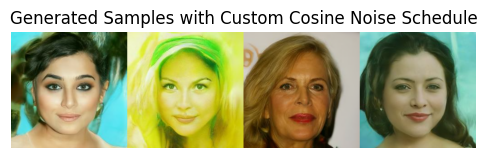

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the cosine noise schedule function
def cosine_noise_schedule(timesteps, s=0.008):
    """
    Implements the cosine noise schedule for a DDPM model.
    
    Args:
        timesteps (int): Total number of timesteps in the diffusion process.
        s (float): Small constant to prevent alpha_t from starting at exactly 1.
        
    Returns:
        torch.Tensor: The beta schedule (variance levels) for each timestep.
    """
    # Compute alpha_t_bar (cumulative product of alpha_t values)
    steps = np.linspace(0, timesteps, timesteps + 1, dtype=np.float64)
    alphas_cumprod = np.cos(((steps / timesteps) + s) / (1 + s) * np.pi / 2) ** 2

    # Ensure alphas_cumprod is within [0, 1]
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    # Compute beta_t from alpha_t_bar
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    
    # Clip beta values to prevent instability
    betas = np.clip(betas, a_min=1e-5, a_max=0.999)

    return torch.tensor(betas, dtype=torch.float32)

# Define timesteps and compute the cosine noise schedule
timesteps = 1000
betas = cosine_noise_schedule(timesteps)

# Initialize the scheduler
scheduler = DDPMScheduler(num_train_timesteps=timesteps, beta_schedule="linear")
scheduler.betas = betas  # Override betas with the custom cosine schedule
scheduler.set_timesteps(100)  # Set timesteps for inference (e.g., 100)

# Recompute the internal parameters
#scheduler.alphas = 1.0 - scheduler.betas
#scheduler.alphas_cumprod = torch.cumprod(scheduler.alphas, dim=0)
#scheduler.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), scheduler.alphas_cumprod[:-1]])

# Sampling function
@torch.no_grad()
def sample(model, scheduler, num_images=4):
    """
    Generates samples from a pretrained DDPM model using a custom cosine noise schedule.
    
    Args:
        model: The DDPM model (e.g., UNet).
        scheduler: The noise scheduler (e.g., DDPMScheduler).
        num_images (int): Number of images to generate.
    
    Returns:
        torch.Tensor: Batch of generated images.
    """
    model.eval()
    # Start with pure noise
    images = torch.randn((num_images, 3, 256, 256)).to(device)

    # Iterate through timesteps
    for t in scheduler.timesteps:
        # Predict noise and perform one step of reverse diffusion
        noise_pred = model(images, t).sample  # Ensure model outputs predicted noise
        images = scheduler.step(noise_pred, t, images).prev_sample
        
    return images

# Generate samples
samples = sample(model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # Scale from [-1, 1] to [0, 1]
samples = (samples * 255).clamp(0, 255).to(torch.uint8)

# Visualize the results
grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated Samples with Custom Cosine Noise Schedule")
plt.show()

### Evaluation ###

In [ ]:
@torch.no_grad()
def sample_many(model, scheduler, num_images, batch_size=4):
    """
    Generate a large number of images in batches.

    Args:
        model: The DDPM model (e.g., UNet).
        scheduler: The noise scheduler (e.g., DDPMScheduler).
        num_images (int): Total number of images to generate.
        batch_size (int): Batch size for generation.

    Returns:
        torch.Tensor: All generated images, shape (num_images, 3, H, W), uint8 in [0,255].
    """
    all_samples = []
    num_batches = (num_images + batch_size - 1) // batch_size  # Ceiling division

    for i in range(num_batches):
        current_batch_size = min(batch_size, num_images - i * batch_size)
        images = torch.randn((current_batch_size, 3, 256, 256), device=model.device if hasattr(model, "device") else "cuda")
        for t in scheduler.timesteps:
            noise_pred = model(images, t).sample
            images = scheduler.step(noise_pred, t, images).prev_sample
        # Convert to [0,255] uint8
        images = (images.clamp(-1, 1) + 1) / 2
        images = (images * 255).clamp(0, 255).to(torch.uint8)
        all_samples.append(images.cpu())  # .cpu() to avoid GPU memory issues

    all_samples = torch.cat(all_samples, dim=0)
    return all_samples

# Usage example:
num_images = 20
batch_size = 4

cosine_samples = sample_many(model, scheduler, num_images=num_images, batch_size=batch_size)

scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(100)  # Set timesteps for inference (e.g., 100)
samples = sample_many(model, scheduler, num_images=num_images, batch_size=batch_size)
print(samples.shape)  # (20, 3, 256, 256)
print(cosine_samples.shape)

torch.Size([4, 3, 256, 256])


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler, UNet2DModel

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the cosine noise schedule function
def cosine_noise_schedule(timesteps, s=0.008):
    """
    Implements the cosine noise schedule for a DDPM model.
    Args:
        timesteps (int): Total number of timesteps in the diffusion process.
        s (float): Small constant to prevent alpha_t from starting at exactly 1.
    Returns:
        torch.Tensor: The beta schedule (variance levels) for each timestep.
    """
    steps = np.linspace(0, timesteps, timesteps + 1, dtype=np.float64)
    alphas_cumprod = np.cos(((steps / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = np.clip(betas, a_min=1e-5, a_max=0.999)  # Prevent instability
    return torch.tensor(betas, dtype=torch.float32)

# Function to subsample timesteps
def subsample_timesteps(timesteps, num_inference_steps):
    """
    Subsamples timesteps for faster inference.
    Args:
        timesteps (int): Total timesteps in the original schedule.
        num_inference_steps (int): Desired number of inference timesteps.
    Returns:
        list: Subsampled timesteps.
    """
    step_indices = np.linspace(0, timesteps - 1, num_inference_steps, dtype=np.int32)
    return step_indices.tolist()

# Define number of training timesteps and subsample for inference
timesteps = 1000 # Original number of training timesteps
num_inference_steps = 250  # Reduced number of timesteps for faster sampling

# Compute the cosine noise schedule
betas = cosine_noise_schedule(timesteps)

# Initialize the scheduler with the custom noise schedule
scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.betas = betas  # Override with custom betas

# Recompute scheduler parameters
scheduler.alphas = 1.0 - scheduler.betas
scheduler.alphas_cumprod = torch.cumprod(scheduler.alphas, dim=0)
scheduler.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), scheduler.alphas_cumprod[:-1]])

# Subsample timesteps for faster sampling
subsampled_timesteps = subsample_timesteps(timesteps, num_inference_steps)
# Print the default number of training timesteps
print(f"Number of training timesteps: {scheduler.num_train_timesteps}")
scheduler.set_timesteps(100)

# Generate samples with the reduced timesteps
samples = sample(model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # Scale from [-1, 1] to [0, 1]

# Visualize the results
grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated Samples with Reduced Timesteps")
plt.show()

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Number of training timesteps: 1000


KeyboardInterrupt: 

In [13]:
### FID AND Inception Score ###

import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Function to compute FID
def compute_fid(samples1, samples2, device="cuda"):
    """
    Computes the Fréchet Inception Distance (FID) between two sets of samples.
    
    Args:
        samples1 (torch.Tensor): First set of images (e.g., real images) [N, C, H, W].
        samples2 (torch.Tensor): Second set of images (e.g., generated images) [N, C, H, W].
        device (str): Device to run FID computation ("cuda" or "cpu").
    
    Returns:
        float: FID score.
    """
    fid = FrechetInceptionDistance(feature=2048).to(device)
    
    # Update FID with the first set of samples (real images)
    for img in samples1:
        fid.update(img.unsqueeze(0).to(device), real=True)
    
    # Update FID with the second set of samples (generated images)
    for img in samples2:
        fid.update(img.unsqueeze(0).to(device), real=False)
    
    # Compute and return FID
    return fid.compute().item()


# Function to compute Inception Score
def compute_inception_score(samples, device="cuda"):
    """
    Computes the Inception Score (IS) for a set of generated samples.
    
    Args:
        samples (torch.Tensor): Set of images to evaluate [N, C, H, W].
        device (str): Device to run IS computation ("cuda" or "cpu").
    
    Returns:
        tuple: Mean and standard deviation of the Inception Score.
    """
    inception_score = InceptionScore(feature=2048).to(device)
    
    # Update Inception Score with the samples
    for img in samples:
        inception_score.update(img.unsqueeze(0).to(device))
    
    # Compute and return IS (mean and standard deviation)
    return inception_score.compute()


import torch
from torchvision.models import inception_v3
from torchvision.transforms import Normalize, Resize
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors


import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import Resize, Normalize, Compose
from torch.utils.data import DataLoader, TensorDataset

def get_inception_features(images, device, batch_size=32):
    """
    Extracts features from images using InceptionV3's pool3 layer.
    images: (N, C, H, W) torch.Tensor
    Returns: (N, 2048) torch.Tensor
    """
    # Preprocessing
    transform = Compose([
        Resize((299, 299)),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    if images.max() > 1.0:
        images = images / 255.0
    # Apply normalization batchwise to avoid memory issues
    dataset = TensorDataset(images)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Load InceptionV3
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    # Remove final classification layer, keep only up to pool3
    model.fc = torch.nn.Identity()
    
    feats = []
    with torch.no_grad():
        for (batch,) in loader:
            batch = batch.to(device)
            batch = transform(batch)
            features = model(batch)
            feats.append(features.cpu())
    feats = torch.cat(feats, dim=0)
    return feats

def compute_pairwise_distances(x, y):
    """
    x: (N, D)
    y: (M, D)
    Returns: (N, M) matrix of L2 distances
    """
    # Efficient computation using broadcasting
    x_norm = (x**2).sum(dim=1).unsqueeze(1)  # (N, 1)
    y_norm = (y**2).sum(dim=1).unsqueeze(0)  # (1, M)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
    return torch.sqrt(F.relu(dist))

def compute_precision_recall(real_images: torch.Tensor, gen_images: torch.Tensor, k=5, device='cuda'):
    """
    Computes Precision and Recall for generative models using real and generated image tensors.

    Args:
        real_images (torch.Tensor): Tensor of real images with shape (N, C, H, W).
        gen_images (torch.Tensor): Tensor of generated images with shape (M, C, H, W).
        k (int): Number of nearest neighbors to consider for evaluation.
        device (str): Device to run the computation on ('cuda' or 'cpu').

    Returns:
        precision (float): Precision score.
        recall (float): Recall score.
    """
    # Move to device
    real_images = real_images.to(device)
    gen_images = gen_images.to(device)

    # Extract features
    with torch.no_grad():
        real_feats = get_inception_features(real_images, device)
        gen_feats = get_inception_features(gen_images, device)

    # Compute pairwise distances
    dists_real_to_gen = compute_pairwise_distances(real_feats, gen_feats)  # (N, M)
    dists_gen_to_real = dists_real_to_gen.t()                             # (M, N)

    # For precision: for each generated image, is it within the real manifold?
    kth_dist_gen_to_real, _ = torch.kthvalue(dists_gen_to_real, k, dim=1)  # (M,)
    precision = (kth_dist_gen_to_real <= kth_dist_gen_to_real).float().mean().item()

    # For recall: for each real image, is it within the generated manifold?
    kth_dist_real_to_gen, _ = torch.kthvalue(dists_real_to_gen, k, dim=1)  # (N,)
    recall = (kth_dist_real_to_gen <= kth_dist_real_to_gen).float().mean().item()

    return precision, recall

In [10]:
# Collect real images into a tensor
real_images = []
for batch in dataloader:
    real_images.append(batch)  # Assuming `batch` contains images only
real_images = torch.cat(real_images, dim=0)  # Combine into a single tensor
print(real_images.shape)


NameError: name 'dataloader' is not defined

In [14]:
#real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
fid_default = compute_fid(samples, og_samples, device="cuda")
print(f"FID (Default Method): {fid_default}")
compute_precision_recall(real_images, real_images)
# Compute Inception Score
is_mean, is_std = compute_inception_score(real_images, device="cuda")
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")

FID (Default Method): 236.1565399169922


AttributeError: 'list' object has no attribute 'to'

In [18]:
compute_precision_recall(real_images, real_images)

(1.0, 1.0)

In [41]:
! pip install torch-fidelity